<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/NN-online/blob/main/5IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras


In this notebook we will learn to use the high-level framework Keras for building neural networks. From now on this will be our default framework to solve ML problems

# Predicting Movie Reviews

In this exercise we are given a set of IMDB movie reviews and we train our model to predict other reviews. The output of the review is either positive or negative so it is a binary classification problem like the ship/not ship problem we dealt with before

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
import numpy as np
#import cupy as np
from keras.utils import to_categorical



###Zip, List comprehension and Dictionaries in Python

list comprehensions are a succinct way to create lists in Python

In [ ]:
x=[i for i in range(5)]
x

using a filter: choose only even numbers from raw

In [ ]:
raw=[1,2,3,4,5,6]
x=[i for i in raw if i%2==0]
x

Operating differently on odd and even  numbers. Note the different syntax from the previous example. When __ONLY__ if is present it appears __after__ the for in syntax. When if else block is present it appears __before__ the for in block

In [ ]:
collatz=[x//2 if x%2==0 else x+1 for x in range(10)]
print([x for x in range(10)])
collatz

zip combines two or more list into a list of tuples

In [ ]:
lpairs=zip(range(0,10,2),range(1,10,2))
rev=[(y,x) for (x,y) in zip(range(0,10,2),range(1,10,2))]
print(list(lpairs))
print(rev)

Dictionaries are (key,value) containers

In [ ]:
## create a dictionary from a list of pairs
dict(rev)

In [ ]:
# create an empty dictionary
d={}
# add (key,value) pairs using associative arrays notation
d['key1']=1
d['key2']=2
# iterate over all the items
for (k,v) in d.items():
  print("key {} has value {}".format(k,v))
## create a dictionary using initialization 
D={"a":0,"b":1,"t":179}
for (k,v) in D.items():
    print("key {} has value {}".format(k,v))


In [ ]:
listW=["one","two","three","four"]
joinSP=" ".join(listW)
print(joinSP)
joinD="-".join(listW)
print(joinD)

String join

## The data

The movie review dataset is a set of 50000 reviews of movies (half training, half test). Each review contains a set of words and is labeled positive (1) or negative (0). For convenience each word index refer to its frequency of occurence in the dataset. For example a word with index 5 is the fifth most frequently used data set. The indices 0,1 and 2 are reserved so 5 really means the third most frequent.

Details about the dataset can be found here [Keras IMDB](https://keras.io/api/datasets/imdb/)

In this exercise we choose only the first 10000 most frequent words to be included. Any word that is not among them is given the index 2.

First we load data set without omitting any words

### Data details

We would like to have an idea about the number of reviews, the average length of a review. Also we compute how many entries with values 0,1,2 and 3. The number 0 is used for padding and 1 to denote the beginning of each sequence. The number 2 is used for missing words. Finally, the number 3 is never used since as you will see later we will shift the indices by 3.

In [ ]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.imdb.load_data()

print("The number of reviews in the x_train data set = {}\n".format(x_train.shape[0]))
print("The average length of reviews = {}".format(np.mean([len(x) for x in x_train])))
print("With standard deviation = {}".format(np.std([len(x) for x in x_train])))

Now when we choose only the first _max_words_ most frequent words and compute the number of 2's in the data set. As you can see the number of 2's is now very large since all the "ignored" words were given the code 2.

In [2]:
max_words=5000
(x_train,y_train),(x_test,y_test)=imdb.load_data(num_words=max_words)
print("The number of 2's in the x_train data set = {}\n".format(sum([1 for x in np.hstack(x_train) if x==2])))

17465344/17464789 [==============================] - 0s 0us/step
The number of 2's in the x_train data set = 592372



### Word index

Keras provides also a dictionary of word to index. We don't need it for training but it helps us get an idea what the reviews are saying in plain English. From that we build a dictionary of index to words. We use the index_to_word to display the first review in the data set.

In [3]:

word_to_index=imdb.get_word_index()
index_to_word=dict([(key,val) for (val,key) in word_to_index.items()])
review = " ".join( [index_to_word.get(i - 3, "***") for i in x_train[0]] )
print(review)

1646592/1641221 [==============================] - 0s 0us/step
*** this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert *** is an amazing actor and now the same being director *** father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for *** and would recommend it to everyone to watch and the fly *** was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also *** to the two little *** that played the *** of norman and paul they were just brilliant children are often left out of the *** list i think because the stars that play them all grown up are such a big *** for the whole film but these children are 

## One hot Encoding

Even though this problem is similar to the image classification problem that we saw, we cannot feed the word indices to our model directly. 
1. First, not all the reviews are the same length. 
1. Second, the same word in different reviews can occur at different position.

For example the two reviews " that was a good movie" and "That movie was good" will be interpreted differently because the **same** words occur at different positions. So we need to do the following

1. Truncate or pad all reviews to contain the same number of words
1. Make sure the same word occurs at the same position in every review. This we do by using one hot encoding.

Suppose that our vocabulary contains only 3 words labeled 1,2 and 3. Further, suppose that two reviews have the values [2,1]  and [1,2] respectively then the one hot representation of both is the same:
[1,1,0] i.e. words 1 and 2 are present but 3 is missing

**NOTE** our representation is a one-hot encoding for __sentences__  __not__ words like it is __usually__ done.



## Implementation Details

The indices of a numpy tensor can be arrays. For example suppose that we are given an array A of size _n_ filled with zeros and we need to set the values at positions 1,13,27 with 1. We can perform the operation in one statement as A[[1,13,27]]=1. Knowing that the function one_hot below goes through every review which is a array of indices and sets the corresponding positions to 1.

Remember that not all sentences have the same length (i.e. number of words) but below we convert each sentence to a fixed sized representation

In [4]:


def one_hot(reviews, nb_words = max_words):
 res = np.zeros((len(reviews), nb_words))
 for i, review in enumerate(reviews):
  res[i, review] = 1
 return res

x_train_one_hot=one_hot(x_train)
x_test_one_hot=one_hot(x_test)

## W converted the sentences from variable
## length to fixed length
print("number of words in sentence {} is {}".format(0,len(x_train[0])))
print("number of words in sentence {} is {}".format(1,len(x_train[1])))

print("the shape of the one-hot encoding is {}".format(x_train_one_hot.shape))


number of words in sentence 0 is 218
number of words in sentence 1 is 189
the shape of the one-hot encoding is (25000, 5000)


### Keras Model

A Keras __model__ can be build from component __layers__. Later one we will look at the __functional__ API in Keras. Now, for simplicity, we will use the __Sequential__ Model which can be build by adding layers to it.

We will build the __logistic regression__ model that we have used before and shown in the figure below

![logistic](https://github.com/hikmatfarhat-ndu/CSC645/blob/master/figures/perceptron.png?raw=1)

First we create a __Sequential__ Model

In [6]:
model=tf.keras.models.Sequential()

Now we start adding __layers__ to it. From the figure above we can see that there are two layers: the __input__ and the __output__

In [7]:
input_shape=(x_train_one_hot.shape[1],)
input=tf.keras.layers.Input(shape=input_shape)
model.add(input)
output=tf.keras.layers.Dense(1,activation="sigmoid")
model.add(output)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 5001      
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________


### Visual representation of the Model

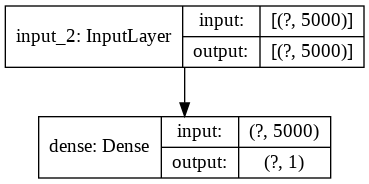

In [8]:
tf.keras.utils.plot_model(model,show_shapes=True)

### Compiling the Model
After building the model we need to find its optimal parameters with respect to the data. To do so we need to specify
1. The optimizer function
1. The loss function

In this exercise we use the Adam optimizer which can be viewed as stochastic gradient descent with __variable__ learning rate

In [9]:
model.compile(optimizer="Adam",loss="binary_crossentropy",metrics=["accuracy"])


## Start trainning

In [11]:
history = model.fit(x_train_one_hot,y_train,batch_size=500,epochs=10)

Epoch 1/10
50/50 [==============================] - 0s 5ms/step - loss: 0.6042 - accuracy: 0.7355
Epoch 2/10
50/50 [==============================] - 0s 5ms/step - loss: 0.4882 - accuracy: 0.8390
Epoch 3/10
50/50 [==============================] - 0s 5ms/step - loss: 0.4262 - accuracy: 0.8634
Epoch 4/10
50/50 [==============================] - 0s 5ms/step - loss: 0.3860 - accuracy: 0.8765
Epoch 5/10
50/50 [==============================] - 0s 5ms/step - loss: 0.3574 - accuracy: 0.8847
Epoch 6/10
50/50 [==============================] - 0s 6ms/step - loss: 0.3357 - accuracy: 0.8910
Epoch 7/10
50/50 [==============================] - 0s 5ms/step - loss: 0.3186 - accuracy: 0.8954
Epoch 8/10
50/50 [==============================] - 0s 5ms/step - loss: 0.3045 - accuracy: 0.8997
Epoch 9/10
50/50 [==============================] - 0s 5ms/step - loss: 0.2927 - accuracy: 0.9024
Epoch 10/10
50/50 [==============================] - 0s 5ms/step - loss: 0.2827 - accuracy: 0.9064


In [12]:
model.evaluate(x_test_one_hot,y_test)


782/782 [==============================] - 1s 2ms/step - loss: 0.3226 - accuracy: 0.8802


[0.32264354825019836, 0.8802000284194946]

In [13]:
y=model.predict(x_test_one_hot)

print(y.shape)
sent=(y>=0.5).astype(int)
print(np.squeeze(sent[0:15]))
print(y_test[0:15])

(25000, 1)
[0 1 1 1 1 1 1 0 1 1 1 0 0 0 1]
[0 1 1 0 1 1 1 0 0 1 1 0 0 0 1]


### History object contains a dictionary

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

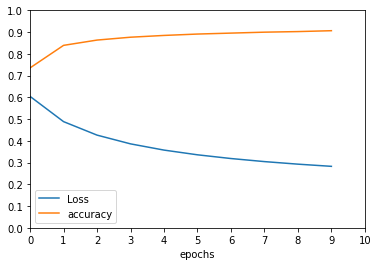

In [43]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.plot(history.epoch,history.history['loss'],label='Loss')
ax.plot(history.epoch,history.history['accuracy'],label='accuracy')
ax.set_xlabel('epochs')
ax.set_xlim(0,10)
ax.set_ylim(0,1)
plt.xticks(range(0,11,1))
plt.yticks(np.arange(0,1.1,0.1))
ax.legend()
plt.show()

In [23]:
  history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## Word Embedding

Our previous approach to modelling sentences does not take into account the syntax. It decides on a sentiment according to the presence or absence of certain words, regardless where they occur in the sentence. For this type of data it seems that this shortcoming doesn't matter but for other applications the particular sequencing of words is important. We could use one-hot encoding __per word__ instead of __per sentence__ like we did above but this becomes infeasible of the number of words is large. Instead we use what is called __word embedding__

### Embedding Layer Example

As an example consider two __integer sequences__ representing two __sentences__ where each sequence contains the integer representation of words and the largesst word encoding is 9. Using an embedding layer we convert each word into a __three dimensional__ vector.

In [ ]:

## this input simulates 2 samples of sequences of length 4 where the largest value is 9
input_array=np.array([[1,8,3,4],[5,3,2,9]])
elayer=tf.keras.layers.Embedding(10,3,input_length=4)

e=elayer(input_array)
print(e.shape)
print(e)

## Using the Embedding Layer 

In [ ]:
x_train=pad_sequences(x_train,maxlen=500)
x_test=pad_sequences(x_test,maxlen=500)
embedding_dim=32
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(max_words,embedding_dim,input_length=500))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)



In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])
history = model.fit(
    x_train,
    y_train,
    batch_size=500,
    epochs=20)

In [ ]:
model.evaluate(x_test,y_test)